In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.utils.class_weight import compute_class_weight

sns.set_theme(style="whitegrid")

## Exploratory Data Analysis

In [2]:
migraine_df = pd.read_csv('migraine_treatment.csv')
migraine_df.head()

,id,time,dos,hatype,age,airq,medication,headache,sex
0,1,-11,753,Aura,30,9.0,continuing,yes,female
1,1,-10,754,Aura,30,7.0,continuing,yes,female
2,1,-9,755,Aura,30,10.0,continuing,yes,female
3,1,-8,756,Aura,30,13.0,continuing,yes,female
4,1,-7,757,Aura,30,18.0,continuing,yes,female


In [3]:
migraine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4152 entries, 0 to 4151
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          4152 non-null   int64  
 1   time        4152 non-null   int64  
 2   dos         4152 non-null   int64  
 3   hatype      4152 non-null   object 
 4   age         4152 non-null   int64  
 5   airq        4152 non-null   float64
 6   medication  4152 non-null   object 
 7   headache    4152 non-null   object 
 8   sex         4152 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 292.1+ KB


In [4]:
# Number of unique patients
migraine_df['id'].nunique()

133

In [5]:
# Check missing values
migraine_df.isnull().sum()

id            0
time          0
dos           0
hatype        0
age           0
airq          0
medication    0
headache      0
sex           0
dtype: int64

In [6]:
# Get one row per unique individual
unique_patients = migraine_df.drop_duplicates(subset='id')

In [7]:
# Continuous variables summary statistics
migraine_df[['dos','age','airq']].describe()

,dos,age,airq
count,4152.000000,4152.000000,4152.000000
mean,646.705925,42.363921,24.826012
std,335.770123,11.201244,9.514274
min,98.000000,18.000000,3.000000
25%,384.000000,33.000000,18.000000
50%,623.000000,44.000000,24.000000
75%,950.000000,50.000000,29.000000
max,1239.000000,66.000000,73.000000


In [8]:
unique_patients[['dos','age','airq']].describe()

,dos,age,airq
count,133.000000,133.000000,133.000000
mean,627.022556,42.157895,24.224060
std,325.934169,11.363046,9.949632
min,98.000000,18.000000,9.000000
25%,380.000000,33.000000,17.000000
50%,586.000000,44.000000,22.000000
75%,919.000000,50.000000,29.000000
max,1219.000000,66.000000,56.000000


In [9]:
# Frequency tables for categorical variables
print(unique_patients['hatype'].value_counts(), "\n")
print(unique_patients['medication'].value_counts(), "\n")
print(unique_patients['headache'].value_counts(), "\n")
print(unique_patients['sex'].value_counts(), "\n")

hatype
No Aura    65
Aura       56
Mixed      12
Name: count, dtype: int64 

medication
continuing    82
reduced       26
none          25
Name: count, dtype: int64 

headache
yes    105
no      28
Name: count, dtype: int64 

sex
female    113
male       20
Name: count, dtype: int64 



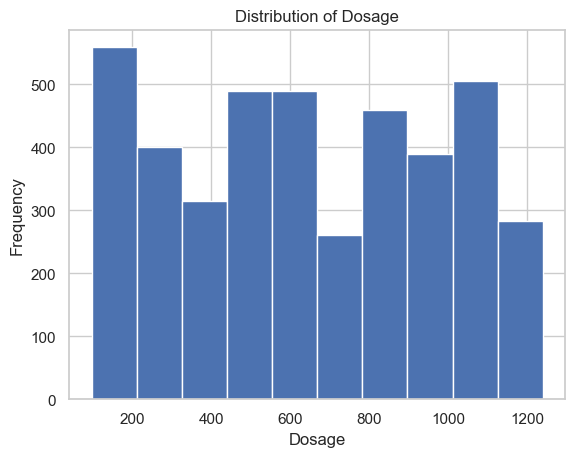

In [10]:
# Histograms for continuous variables
migraine_df['dos'].hist(bins=10)
plt.title('Distribution of Dosage')
plt.xlabel('Dosage')
plt.ylabel('Frequency')
plt.show()

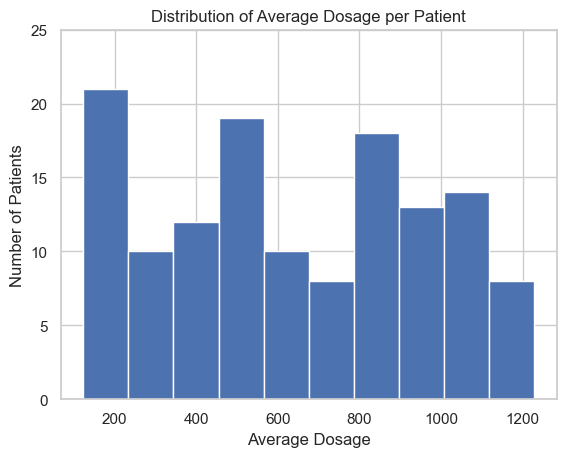

In [11]:
# Compute mean dosage per unique patient
avg_dosage = migraine_df.groupby('id', as_index=False)['dos'].mean()

# Plot histogram of mean dosage
avg_dosage['dos'].hist(bins=10)
plt.ylim(0, 25)
plt.title('Distribution of Average Dosage per Patient')
plt.xlabel('Average Dosage')
plt.ylabel('Number of Patients')
plt.show()

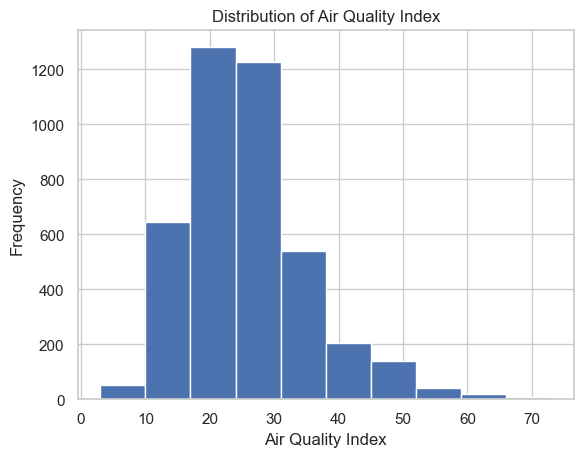

In [12]:
# Air Quality Index histogram
migraine_df['airq'].hist(bins=10)
plt.title('Distribution of Air Quality Index')
plt.xlabel('Air Quality Index')
plt.ylabel('Frequency')
plt.show()

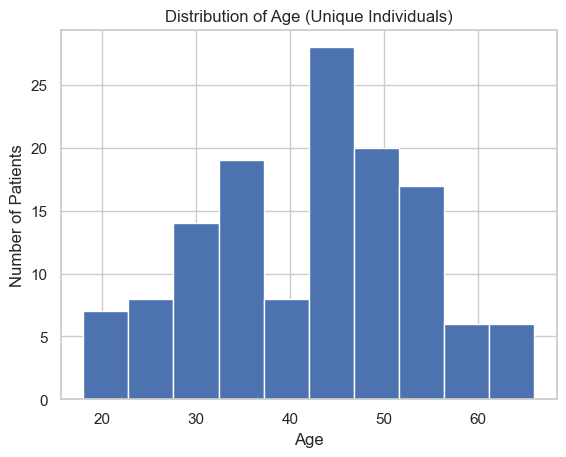

In [13]:
# Plot histogram for unique ages
unique_patients['age'].hist(bins=10)
plt.title('Distribution of Age (Unique Individuals)')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.show()

In [14]:
# Headache incidence by sex
pd.crosstab(unique_patients['sex'], unique_patients['headache'])

headache,no,yes
sex,,
female,23,90
male,5,15


In [15]:
# Mean dosage by medication type
unique_patients.groupby('medication')['dos'].mean()

medication
continuing    640.50
none          622.36
reduced       589.00
Name: dos, dtype: float64

In [16]:
# Average air quality when headache=yes vs no
unique_patients.groupby('headache')['airq'].mean()

headache
no     25.335714
yes    23.927619
Name: airq, dtype: float64

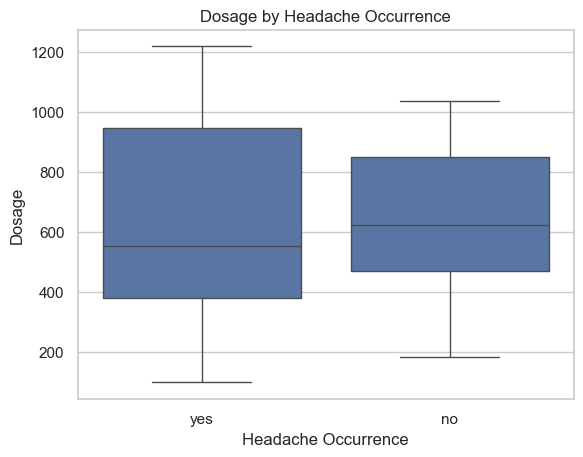

In [17]:
# Boxplot of dosage by headache occurrence
sns.boxplot(x='headache', y='dos', data=unique_patients)
plt.title('Dosage by Headache Occurrence')
plt.xlabel('Headache Occurrence')
plt.ylabel('Dosage')
plt.show()

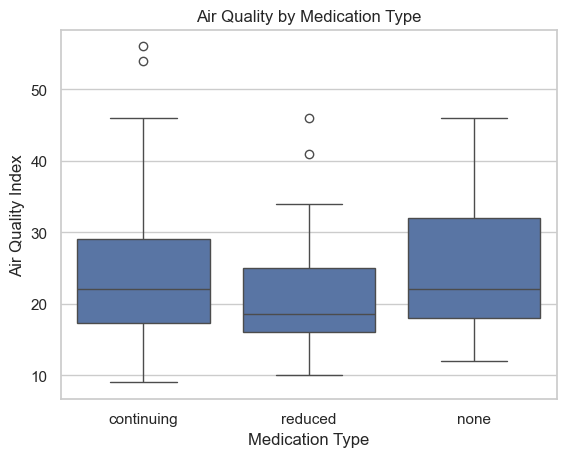

In [18]:
# Boxplot of air quality by medication type
sns.boxplot(x='medication', y='airq', data=unique_patients)
plt.title('Air Quality by Medication Type')
plt.xlabel('Medication Type')
plt.ylabel('Air Quality Index')
plt.show()

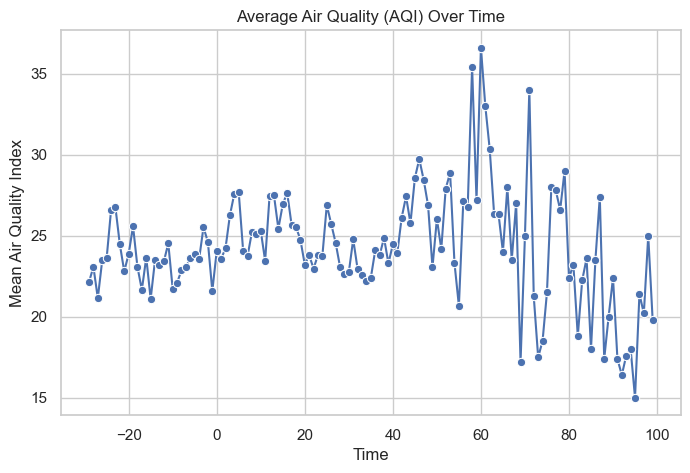

In [19]:
# Average air quality by time
airq_trend = migraine_df.groupby('time')['airq'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.lineplot(data=airq_trend, x='time', y='airq', marker='o')
plt.title('Average Air Quality (AQI) Over Time')
plt.xlabel('Time')
plt.ylabel('Mean Air Quality Index')
plt.grid(True)
plt.show()

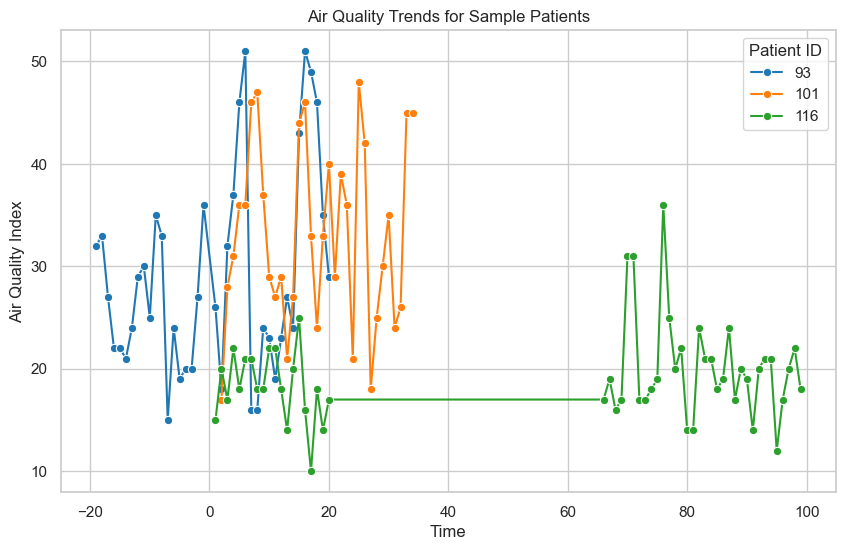

In [20]:
# Air quality trends for a few sample patients
sample_ids = migraine_df['id'].sample(3, random_state=16)
subset = migraine_df[migraine_df['id'].isin(sample_ids)]

plt.figure(figsize=(10,6))
sns.lineplot(data=subset, x='time', y='airq', hue='id', marker='o', palette='tab10')
plt.title('Air Quality Trends for Sample Patients')
plt.xlabel('Time')
plt.ylabel('Air Quality Index')
plt.legend(title='Patient ID')
plt.show()


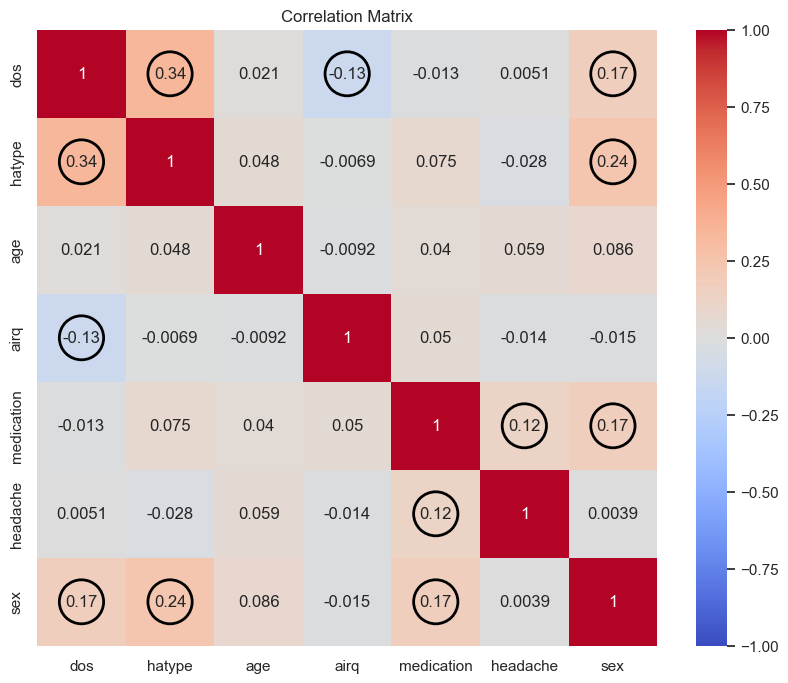

In [21]:
# Correlation matrix
# Convert categorical variables to numeric for correlation analysis
migraine_df_heatmap = migraine_df.copy()
migraine_df_heatmap = migraine_df_heatmap.drop(columns=['id', 'time'])

cat_vars = ['hatype', 'medication', 'headache', 'sex']
for var in cat_vars:
    migraine_df_heatmap[var] = pd.factorize(migraine_df_heatmap[var])[0]

# Compute correlation matrix
corr = migraine_df_heatmap.corr().astype(float)  # Ensure all values are float

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Overlay circles where |r| > 0.1
for i in range(len(corr)):
    for j in range(len(corr)):
        if abs(float(corr.iloc[i, j])) > 0.1 and i != j:
            plt.gca().add_patch(Circle((j + 0.5, i + 0.5), 0.25,
                                           fill=False, color='black', linewidth=2))

plt.title('Correlation Matrix')
plt.show()

In [22]:
def most_frequent(x):
    # Returns the mode; if tie, returns the first
    return x.mode()[0]

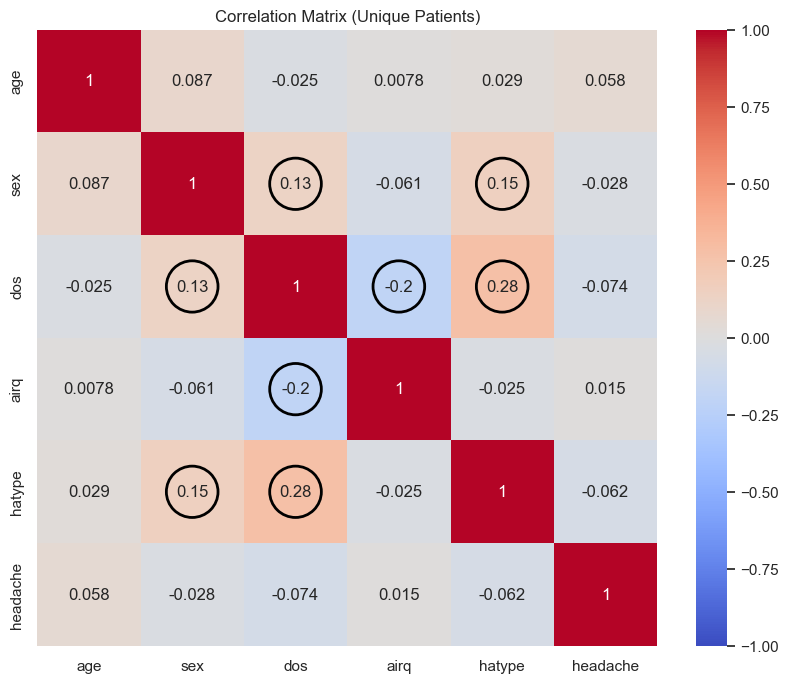

In [23]:
# Correlation matrix
# Convert categorical variables to numeric for correlation analysis
migraine_df_heatmap_unique = migraine_df.groupby('id').agg({
    'age': 'first',           # or 'mean' if it changes over time
    'sex': 'first',
    'dos': 'mean',            # average dose per patient
    'airq': 'mean',           # average air quality per patient
    'hatype': most_frequent,
    'headache': most_frequent  # most frequent headache type per patient
}).reset_index()

migraine_df_heatmap_unique = migraine_df_heatmap_unique.drop(columns=['id'])

cat_vars = ['hatype', 'headache', 'sex']
for var in cat_vars:
    migraine_df_heatmap_unique[var] = pd.factorize(migraine_df_heatmap_unique[var])[0]

# Compute correlation matrix
corr = migraine_df_heatmap_unique.corr().astype(float)  # Ensure all values are float

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Overlay circles where |r| > 0.1
for i in range(len(corr)):
    for j in range(len(corr)):
        if abs(float(corr.iloc[i, j])) > 0.1 and i != j:
            plt.gca().add_patch(Circle((j + 0.5, i + 0.5), 0.25,
                                           fill=False, color='black', linewidth=2))

plt.title('Correlation Matrix (Unique Patients)')
plt.show()

## Modelling 

In [24]:
scaler = StandardScaler()
migraine_df[['age', 'dos', 'airq']] = scaler.fit_transform(migraine_df[['age', 'dos', 'airq']])

# Ensure dependent variable is numeric
migraine_df['headache_ord'] = migraine_df['headache'].astype('category').cat.codes
y = migraine_df['headache_ord'].astype(int)

migraine_df['headache_lag1'] = migraine_df.groupby('id')['headache_ord'].shift(1)
migraine_df = migraine_df.dropna()

# Encode categorical predictors as dummies and ensure numeric
X = pd.get_dummies(migraine_df[['age','dos','airq','sex']], drop_first=True)
X['headache_lag1'] = migraine_df['headache_lag1'].astype(int)
X = X.astype(float)  # Force numeric type

# Drop any rows with NaNs (OrderedModel cannot handle them)
Xy = pd.concat([X, y], axis=1).dropna()
X_clean = Xy[X.columns]
y_clean = Xy['headache_ord']

# Fit Ordered Logit
model = OrderedModel(y_clean, X_clean, distr='logit')
res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.569907
         Iterations: 25
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:           headache_ord   Log-Likelihood:                -2290.5
Model:                   OrderedModel   AIC:                             4593.
Method:            Maximum Likelihood   BIC:                             4631.
Date:                Wed, 15 Oct 2025                                         
Time:                        17:39:55                                         
No. Observations:                4019                                         
Df Residuals:                    4013                                         
Df Model:                           5                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

In [25]:
# If each row = a visit
num_visits_per_patient = migraine_df.groupby('id').size().reset_index(name='num_visits')

# OR if num_visits is already a column, sum it
# num_visits_per_patient = migraine_df.groupby('id', as_index=False)['num_visits'].sum()
# Take patient-level covariates (e.g., age, sex, average dosage, avg air quality)
patient_covars = migraine_df.groupby('id').agg({
    'age': 'first',           # or 'mean' if it changes over time
    'sex': 'first',
    'dos': 'mean',            # average dose per patient
    'airq': 'mean',           # average air quality per patient
    'hatype': most_frequent   # most frequent headache type per patient
}).reset_index()

# Merge with counts
patient_data = pd.merge(patient_covars, num_visits_per_patient, on='id')

In [26]:
patient_data

,id,age,sex,dos,airq,hatype,num_visits
0,1,-1.103932,female,0.400634,-0.767329,Aura,19
1,2,-0.568213,female,-1.451388,-0.239727,Aura,44
2,3,-1.282505,female,-1.440760,-0.025891,Aura,69
3,4,-0.836072,female,-1.557204,0.011719,Aura,32
4,5,1.842524,female,-1.518203,0.041451,Aura,59
...,...,...,...,...,...,...,...
128,129,-1.996797,female,1.690286,-0.518980,Mixed,27
129,130,1.038945,female,1.701649,0.190067,No Aura,41
130,131,0.056793,male,1.711986,0.222342,Mixed,34
131,132,-0.121780,female,1.734413,0.250655,No Aura,19


In [27]:
# Poisson
poisson_model = smf.glm('num_visits ~ age + dos + airq + C(sex) + C(hatype)',
                        data=patient_data,
                        family=sm.families.Poisson())
poisson_res = poisson_model.fit()
print(poisson_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             num_visits   No. Observations:                  133
Model:                            GLM   Df Residuals:                      126
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -885.57
Date:                Wed, 15 Oct 2025   Deviance:                       1090.1
Time:                        17:39:55   Pearson chi2:                 1.32e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1764
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.3927 

In [28]:
# Negative Binomial (if overdispersion)
nb_model = smf.glm('num_visits ~ age + dos + airq + C(sex) + C(hatype)',
                   data=patient_data,
                   family=sm.families.NegativeBinomial(alpha=1.0))
nb_res = nb_model.fit()
print(nb_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             num_visits   No. Observations:                  133
Model:                            GLM   Df Residuals:                      126
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -588.09
Date:                Wed, 15 Oct 2025   Deviance:                       33.347
Time:                        17:39:55   Pearson chi2:                     43.4
No. Iterations:                     6   Pseudo R-squ. (CS):           0.006122
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.3900 

In [29]:
patient_data['hatype'] = pd.Categorical(
    patient_data['hatype'],
    categories=['No Aura', 'Mixed', 'Aura'],  # from least to most severe
    ordered=True
)
patient_data['hatype_ord'] = patient_data['hatype'].cat.codes

In [30]:
patient_data.head()

,id,age,sex,dos,airq,hatype,num_visits,hatype_ord
0,1,-1.103932,female,0.400634,-0.767329,Aura,19,2
1,2,-0.568213,female,-1.451388,-0.239727,Aura,44,2
2,3,-1.282505,female,-1.440760,-0.025891,Aura,69,2
3,4,-0.836072,female,-1.557204,0.011719,Aura,32,2
4,5,1.842524,female,-1.518203,0.041451,Aura,59,2


In [32]:
X = pd.get_dummies(patient_data[['age', 'dos', 'airq', 'sex']], drop_first=True)
y = patient_data['hatype_ord']

X = X.astype(float)
data = pd.concat([X, y], axis=1).dropna()
X_clean = data[X.columns]
y_clean = data['hatype_ord']

In [ ]:
# --- compute weights ---
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_clean),
                                     y=y_clean)
class_weights = dict(zip(np.unique(y_clean), class_weights))

weights = y_clean.map(class_weights)

# --- combine features + label ---
df_full = pd.concat([X_clean, y_clean], axis=1)

# --- replicate each row proportional to its weight ---
rows = []
for (idx, row), w in zip(df_full.iterrows(), weights):
    repeat_n = int(np.ceil(w))
    rows.append(pd.DataFrame([row.values] * repeat_n, columns=df_full.columns))

weighted_df = pd.concat(rows, ignore_index=True)

# --- separate X and y again ---
X_w = weighted_df[X_clean.columns]
y_w = weighted_df['hatype_ord']

# --- fit ordered probit ---
model_w = OrderedModel(y_w, X_w, distr='probit')
res_w = model_w.fit(method='bfgs')
print(res_w.summary())


Optimization terminated successfully.
         Current function value: 1.074701
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:             hatype_ord   Log-Likelihood:                -181.62
Model:                   OrderedModel   AIC:                             375.2
Method:            Maximum Likelihood   BIC:                             394.0
Date:                Wed, 15 Oct 2025                                         
Time:                        18:01:05                                         
No. Observations:                 169                                         
Df Residuals:                     163                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [ ]:
# model = OrderedModel(
#     y_clean,
#     X_clean,
#     distr='probit'  # 'logit' for ordered logit
# )

# res = model.fit(method='bfgs')
# print(res.summary())

Optimization terminated successfully.
         Current function value: 0.909289
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:             hatype_ord   Log-Likelihood:                -120.94
Model:                   OrderedModel   AIC:                             253.9
Method:            Maximum Likelihood   BIC:                             271.2
Date:                Wed, 15 Oct 2025                                         
Time:                        17:41:43                                         
No. Observations:                 133                                         
Df Residuals:                     127                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [54]:
# pred_probs = res.model.predict(res.params, exog=X_clean)

pred_probs = res_w.model.predict(res_w.params, exog=X_w)

In [60]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Convert predicted probabilities to DataFrame with explicit class names
pred_probs_df = pd.DataFrame(pred_probs, columns=['No Aura', 'Mixed', 'Aura'])

# Get predicted class index
pred_classes = pred_probs_df.idxmax(axis=1)

# True classes (align indexes)
true_classes = y_w.map({0: 'No Aura', 1: 'Mixed', 2: 'Aura'})

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=['No Aura', 'Mixed', 'Aura'])
print(pd.DataFrame(cm,
                   index=['Actual No Aura', 'Actual Mixed', 'Actual Aura'],
                   columns=['Pred No Aura', 'Pred Mixed', 'Pred Aura']))

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, zero_division=0))


                Pred No Aura  Pred Mixed  Pred Aura
Actual No Aura            45           0         20
Actual Mixed              32           0         16
Actual Aura               30           0         26

Classification Report:
              precision    recall  f1-score   support

        Aura       0.42      0.46      0.44        56
       Mixed       0.00      0.00      0.00        48
     No Aura       0.42      0.69      0.52        65

    accuracy                           0.42       169
   macro avg       0.28      0.39      0.32       169
weighted avg       0.30      0.42      0.35       169



In [58]:
import numpy as np

missing_classes = set(np.unique(true_classes)) - set(np.unique(pred_classes))
print("Classes not predicted:", missing_classes)


Classes not predicted: {'Mixed'}


In [59]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Macro F1:", f1_score(true_classes, pred_classes, average='macro', zero_division=0))

Macro F1: 0.32131126001839444
